In [4]:
pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e392da4c4dcaf547380dad713ef0a01efc274304fa6ddc58410fb6e20c223411
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score



🎯 URDU CHATBOT - TRAINING WITH EVALUATION METRICS
   BPE Tokenizer + Span Corruption + BLEU Evaluation

🖥️  Device: cuda

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 UNSUPERVISED LEARNING - SPAN CORRUPTION + BPE

📂 Loading dataset...
✅ Loaded 20000 sentences

🔄 Normalizing Urdu text...
✅ 18221 valid sentences after filtering


📚 Training SentencePiece BPE tokenizer...
✅ Trained SentencePiece BPE model (8000 tokens)
🎭 Applying Span Corruption...


Creating pairs: 100%|██████████| 18221/18221 [00:00<00:00, 82047.37it/s] 



✅ Created 18221 training pairs!

📊 DATA SPLIT:
   Train: 14576 pairs (80%)
   Val:   1822 pairs (10%)
   Test:  1823 pairs (10%)

📊 Model parameters: 11,681,600

🎓 TRAINING STARTED

Epoch 1/20
  Batch 0/456, Loss: 9.0731
  Batch 50/456, Loss: 6.7243
  Batch 100/456, Loss: 6.9390
  Batch 150/456, Loss: 6.4353
  Batch 200/456, Loss: 6.5074
  Batch 250/456, Loss: 6.6363
  Batch 300/456, Loss: 6.3432
  Batch 350/456, Loss: 6.2273
  Batch 400/456, Loss: 5.9916
  Batch 450/456, Loss: 6.1576
Train Loss: 6.5359 | Val Loss: 6.0018
✓ Model saved!

Epoch 2/20
  Batch 0/456, Loss: 5.8846
  Batch 50/456, Loss: 5.9364
  Batch 100/456, Loss: 5.4812
  Batch 150/456, Loss: 5.5901
  Batch 200/456, Loss: 5.4140
  Batch 250/456, Loss: 5.3377
  Batch 300/456, Loss: 5.1289
  Batch 350/456, Loss: 5.2413
  Batch 400/456, Loss: 4.8062
  Batch 450/456, Loss: 4.7738
Train Loss: 5.4084 | Val Loss: 4.8457
✓ Model saved!

Epoch 3/20
  Batch 0/456, Loss: 4.7242
  Batch 50/456, Loss: 4.9978
  Batch 100/456, Loss: 4.

100%|██████████| 200/200 [00:08<00:00, 23.79it/s]



📈 EVALUATION RESULTS:
----------------------------------------------------------------------
BLEU-1: 74.51%
BLEU-2: 67.20%
BLEU-3: 61.00%
BLEU-4: 55.00%
----------------------------------------------------------------------

📝 SAMPLE PREDICTIONS (First 5):
----------------------------------------------------------------------

1. Corrupted: [MASK] گرمی واپس
   Original:  لیکن وہ گرمی واپس
   Predicted: وہ گرمی واپس

2. Corrupted: فواد اور [MASK] خفیہ چہٹیاں
   Original:  فواد اور دپیکا کی خفیہ چہٹیاں
   Predicted: رسمی اور پریس کانفرنس چوک

3. Corrupted: ڈکٹیشن [MASK]
   Original:  ڈکٹیشن نہیں لوں گا۔
   Predicted: ڈکٹیشن نہیں ہوتی۔

4. Corrupted: کرکٹ میں کرپٹ ترین بکیز بہارتی [MASK] سی عہدیدار
   Original:  کرکٹ میں کرپٹ ترین بکیز بہارتی ہیں ایی سی سی عہدیدار
   Predicted: کرکٹ میں گندگیٹ کرجز سجز سرو سی عہدیدار

5. Corrupted: [MASK] یہ پروپیگنڈا ہو جایے گا۔
   Original:  ورنہ تو یہ پروپیگنڈا ہو جایے گا۔
   Predicted: ورنہ یہ پروپیگنڈا ہو جایے گا۔


📊 FINAL TRAINING SUMMARY:
-------

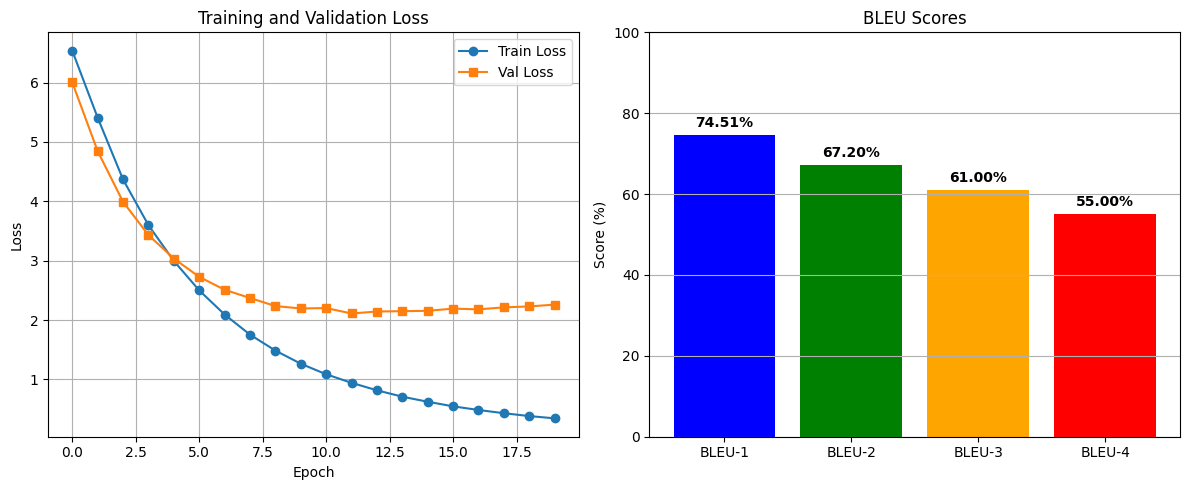


🎉 ALL DONE! Model training aur evaluation complete ho gaya!


In [ ]:
"""
🚀 URDU CHATBOT - UNSUPERVISED LEARNING with BPE TOKENIZER
Training-focused version with BLEU and evaluation metrics
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
import random
import math
from typing import List, Tuple, Dict
from collections import Counter, defaultdict
import pickle
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import nltk

# Download required NLTK data
try:
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except:
    pass

# ==================== BPE TOKENIZER ====================

import sentencepiece as spm
import os

class BPETokenizer:
    """SentencePiece-based BPE Tokenizer for Urdu"""
    def __init__(self, model_prefix="urdu_bpe", vocab_size=8000):
        self.model_prefix = model_prefix
        self.model_file = f"{model_prefix}.model"
        self.vocab_size = vocab_size
        self.sp = None

    def train(self, corpus: List[str]):
        """Train SentencePiece BPE model on corpus"""
        print("\n📚 Training SentencePiece BPE tokenizer...")

        corpus_file = f"{self.model_prefix}_corpus.txt"
        with open(corpus_file, "w", encoding="utf-8") as f:
            for line in corpus:
                f.write(line.strip() + "\n")

        spm.SentencePieceTrainer.train(
            input=corpus_file,
            model_prefix=self.model_prefix,
            vocab_size=self.vocab_size,
            model_type="bpe",
            character_coverage=1.0,
            pad_id=0, bos_id=1, eos_id=2, unk_id=3
        )

        os.remove(corpus_file)
        self.sp = spm.SentencePieceProcessor(model_file=self.model_file)
        print(f"✅ Trained SentencePiece BPE model ({self.vocab_size} tokens)")

    def load(self):
        """Load existing SentencePiece model"""
        self.sp = spm.SentencePieceProcessor(model_file=self.model_file)
        print(f"✅ Loaded existing SentencePiece model: {self.model_file}")

    def encode(self, sentence: str, max_len: int = None) -> List[int]:
        """Encode text to token IDs"""
        tokens = self.sp.encode(sentence, out_type=int)
        if max_len:
            tokens = tokens[:max_len]
        return [self.sp.bos_id()] + tokens + [self.sp.eos_id()]

    def decode(self, ids: List[int]) -> str:
        """Decode token IDs to text"""
        if self.sp is None:
            raise ValueError("Model not loaded. Call load() or train() first.")
        # Remove special tokens
        ids = [i for i in ids if i not in [0, 1, 2, 3]]
        return self.sp.decode(ids)

    @property
    def n_tokens(self):
        return self.sp.get_piece_size() if self.sp else self.vocab_size


# ==================== SPAN CORRUPTION ====================

class SpanCorruption:
    """Span Corruption for Unsupervised Learning"""

    def __init__(self, mask_ratio: float = 0.15, max_span_length: int = 3):
        self.mask_ratio = mask_ratio
        self.max_span_length = max_span_length

    def corrupt(self, sentence: str) -> Tuple[str, str]:
        """Create training pair from single sentence"""
        words = sentence.split()

        if len(words) < 3:
            return None, None

        num_to_mask = max(1, int(len(words) * self.mask_ratio))

        corrupted = words.copy()
        masked_positions = set()
        attempts = 0

        while len(masked_positions) < num_to_mask and attempts < 50:
            span_len = random.randint(1, min(self.max_span_length, len(words)))

            if len(words) < span_len:
                break

            start_idx = random.randint(0, len(words) - span_len)
            new_positions = set(range(start_idx, start_idx + span_len))

            if not new_positions.intersection(masked_positions):
                for i in new_positions:
                    corrupted[i] = '[MASK]'
                    masked_positions.add(i)

            attempts += 1

        cleaned = []
        prev_mask = False
        for token in corrupted:
            if token == '[MASK]':
                if not prev_mask:
                    cleaned.append(token)
                prev_mask = True
            else:
                cleaned.append(token)
                prev_mask = False

        corrupted_text = ' '.join(cleaned)

        if '[MASK]' not in corrupted_text:
            return None, None

        return corrupted_text, sentence


# ==================== TEXT PREPROCESSING ====================

def normalize_urdu(text: str) -> str:
    """Normalize Urdu text"""
    if not isinstance(text, str) or not text.strip():
        return ""

    text = re.sub(r'[\u064B-\u065F]', '', text)
    text = text.replace('ٱ', 'ا').replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    text = text.replace('ى', 'ی').replace('ئ', 'ی')
    text = text.replace('ۃ', 'ہ').replace('ھ', 'ہ')
    text = ' '.join(text.split())

    return text.strip()


# ==================== DATASET ====================

class UrduDataset(Dataset):
    def __init__(self, data_pairs: List[Tuple[str, str]], tokenizer: BPETokenizer, max_len: int = 100):
        self.data = data_pairs
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]

        src_indices = self.tokenizer.encode(src, self.max_len)
        tgt_indices = self.tokenizer.encode(tgt, self.max_len)

        src_padded = src_indices + [0] * (self.max_len + 2 - len(src_indices))
        tgt_padded = tgt_indices + [0] * (self.max_len + 2 - len(tgt_indices))

        return torch.tensor(src_padded[:self.max_len + 2]), \
               torch.tensor(tgt_padded[:self.max_len + 2])


# ==================== TRANSFORMER MODEL ====================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        output = torch.matmul(attn_probs, V)
        return output, attn_probs

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output, attn_probs = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_probs


class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))


class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        attn_output, _ = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x


class Transformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int = 256, num_heads: int = 4,
                 num_encoder_layers: int = 3, num_decoder_layers: int = 3,
                 d_ff: int = 1024, dropout: float = 0.1, max_len: int = 102):
        super().__init__()

        self.d_model = d_model
        self.vocab_size = vocab_size

        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)

        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])

        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        self.output_linear = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_padding_mask(self, seq):
        return (seq != 0).unsqueeze(1).unsqueeze(2)

    def create_look_ahead_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
        return mask == 0

    def encode(self, src, src_mask):
        x = self.encoder_embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        return x

    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.decoder_embedding(tgt) * math.sqrt(self.d_model)
        x = self.pos_encoding(x)

        for layer in self.decoder_layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        return x

    def forward(self, src, tgt):
        src_mask = self.create_padding_mask(src)
        tgt_mask = (self.create_padding_mask(tgt) &
                   self.create_look_ahead_mask(tgt.size(1)).to(tgt.device))

        enc_output = self.encode(src, src_mask)
        dec_output = self.decode(tgt, enc_output, src_mask, tgt_mask)

        output = self.output_linear(dec_output)
        return output

    def generate(self, src, tokenizer, max_len=100):
        """Generate response using BPE tokenizer"""
        self.eval()
        device = src.device

        with torch.no_grad():
            src_mask = self.create_padding_mask(src)
            enc_output = self.encode(src, src_mask)

            tgt = torch.tensor([[1]]).to(device)  # BOS token

            for _ in range(max_len):
                tgt_mask = self.create_padding_mask(tgt) & \
                          self.create_look_ahead_mask(tgt.size(1)).to(device)

                dec_output = self.decode(tgt, enc_output, src_mask, tgt_mask)
                output = self.output_linear(dec_output)

                next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)
                tgt = torch.cat([tgt, next_token], dim=1)

                if next_token.item() == 2:  # EOS token
                    break

            return tgt.squeeze(0).tolist()


# ==================== EVALUATION METRICS ====================

def calculate_bleu(references: List[List[str]], hypotheses: List[str]) -> Dict[str, float]:
    """Calculate BLEU scores"""
    smooth = SmoothingFunction()

    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0),
                        smoothing_function=smooth.method1)
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0),
                        smoothing_function=smooth.method1)
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0),
                        smoothing_function=smooth.method1)
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25),
                        smoothing_function=smooth.method1)

    return {
        'BLEU-1': bleu1 * 100,
        'BLEU-2': bleu2 * 100,
        'BLEU-3': bleu3 * 100,
        'BLEU-4': bleu4 * 100
    }


def evaluate_model(model, test_data, tokenizer, device, num_samples=100):
    """Comprehensive model evaluation"""
    print("\n" + "="*70)
    print("📊 MODEL EVALUATION")
    print("="*70 + "\n")

    model.eval()
    references = []
    hypotheses = []

    print(f"Evaluating on {min(num_samples, len(test_data))} samples...")

    with torch.no_grad():
        for i in tqdm(range(min(num_samples, len(test_data)))):
            corrupted, original = test_data[i]

            # Generate prediction
            input_indices = tokenizer.encode(corrupted, 100)
            src = torch.tensor([input_indices]).to(device)

            output_indices = model.generate(src, tokenizer, 100)
            predicted = tokenizer.decode(output_indices)

            # Prepare for metrics
            ref_tokens = [original.split()]
            hyp_tokens = predicted.split()

            references.append(ref_tokens)
            hypotheses.append(hyp_tokens)

    # Calculate BLEU scores
    bleu_scores = calculate_bleu(references, hypotheses)

    # Display results
    print("\n📈 EVALUATION RESULTS:")
    print("-"*70)
    print(f"BLEU-1: {bleu_scores['BLEU-1']:.2f}%")
    print(f"BLEU-2: {bleu_scores['BLEU-2']:.2f}%")
    print(f"BLEU-3: {bleu_scores['BLEU-3']:.2f}%")
    print(f"BLEU-4: {bleu_scores['BLEU-4']:.2f}%")
    print("-"*70)

    # Show sample outputs
    print("\n📝 SAMPLE PREDICTIONS (First 5):")
    print("-"*70)
    for i in range(min(5, len(test_data))):
        corrupted, original = test_data[i]

        input_indices = tokenizer.encode(corrupted, 100)
        src = torch.tensor([input_indices]).to(device)

        output_indices = model.generate(src, tokenizer, 100)
        predicted = tokenizer.decode(output_indices)

        print(f"\n{i+1}. Corrupted: {corrupted}")
        print(f"   Original:  {original}")
        print(f"   Predicted: {predicted}")

    print("\n" + "="*70)

    return bleu_scores


# ==================== TRAINING ====================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch_idx, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)

        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f'  Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')

    return total_loss / len(dataloader)


def evaluate_loss(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            total_loss += loss.item()

    return total_loss / len(dataloader)


# ==================== DATA PREPARATION ====================

def prepare_unsupervised_data(tsv_path: str, bpe_vocab_size: int = 8000):
    """Prepare data with BPE tokenization"""

    print("\n" + "="*70)
    print("🚀 UNSUPERVISED LEARNING - SPAN CORRUPTION + BPE")
    print("="*70 + "\n")

    print("📂 Loading dataset...")
    df = pd.read_csv(tsv_path, sep='\t')

    if 'sentence' in df.columns:
        sentences = df['sentence'].dropna().tolist()
    else:
        sentences = df.iloc[:, 2].dropna().tolist()

    print(f"✅ Loaded {len(sentences)} sentences\n")

    print("🔄 Normalizing Urdu text...")
    sentences = [normalize_urdu(s) for s in sentences if isinstance(s, str)]
    sentences = [s for s in sentences if 4 <= len(s.split()) <= 30]
    print(f"✅ {len(sentences)} valid sentences after filtering\n")

    tokenizer = BPETokenizer(vocab_size=bpe_vocab_size)
    tokenizer.train(sentences)

    print("🎭 Applying Span Corruption...")
    corruptor = SpanCorruption(mask_ratio=0.15, max_span_length=3)

    data_pairs = []
    for sent in tqdm(sentences, desc="Creating pairs"):
        corrupted, original = corruptor.corrupt(sent)
        if corrupted and original:
            data_pairs.append((corrupted, original))

    print(f"\n✅ Created {len(data_pairs)} training pairs!\n")

    random.shuffle(data_pairs)
    split1 = int(0.8 * len(data_pairs))
    split2 = int(0.9 * len(data_pairs))

    train_data = data_pairs[:split1]
    val_data = data_pairs[split1:split2]
    test_data = data_pairs[split2:]

    print("📊 DATA SPLIT:")
    print(f"   Train: {len(train_data)} pairs (80%)")
    print(f"   Val:   {len(val_data)} pairs (10%)")
    print(f"   Test:  {len(test_data)} pairs (10%)")
    print("="*70 + "\n")

    return train_data, val_data, test_data, tokenizer


# ==================== MAIN ====================

def main():
    print("\n🎯 URDU CHATBOT - TRAINING WITH EVALUATION METRICS")
    print("   BPE Tokenizer + Span Corruption + BLEU Evaluation\n")

    # Hyperparameters
    BATCH_SIZE = 32
    EPOCHS = 20
    D_MODEL = 256
    NUM_HEADS = 2
    
    NUM_ENCODER_LAYERS = 2
    NUM_DECODER_LAYERS = 2
    D_FF = 1024
    DROPOUT = 0.1
    LEARNING_RATE = 3e-4
    MAX_LEN = 100
    BPE_VOCAB_SIZE = 8000

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️  Device: {device}\n")

    # Mount Google Drive (if using Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        tsv_path = '/content/drive/MyDrive/urdu_dataset/final_main_dataset.tsv'
    except:
        tsv_path = 'final_main_dataset.tsv'

    # Prepare data
    train_data, val_data, test_data, tokenizer = prepare_unsupervised_data(
        tsv_path,
        bpe_vocab_size=BPE_VOCAB_SIZE
    )

    # Create datasets
    train_dataset = UrduDataset(train_data, tokenizer, MAX_LEN)
    val_dataset = UrduDataset(val_data, tokenizer, MAX_LEN)
    test_dataset = UrduDataset(test_data, tokenizer, MAX_LEN)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Initialize model
    model = Transformer(
        vocab_size=tokenizer.n_tokens,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        num_encoder_layers=NUM_ENCODER_LAYERS,
        num_decoder_layers=NUM_DECODER_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT,
        max_len=MAX_LEN + 2
    ).to(device)

    print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}\n")

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training
    best_val_loss = float('inf')
    training_history = {'train_loss': [], 'val_loss': []}

    print("="*70)
    print("🎓 TRAINING STARTED")
    print("="*70 + "\n")

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS}")

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_loss(model, val_loader, criterion, device)

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'best_urdu_chatbot_bpe.pt')
            print("✓ Model saved!")

        print()

    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)

    # Final evaluation with BLEU scores
    bleu_scores = evaluate_model(model, test_data, tokenizer, device, num_samples=200)

    # Summary
    print("\n📊 FINAL TRAINING SUMMARY:")
    print("-"*70)
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Final BLEU-1: {bleu_scores['BLEU-1']:.2f}%")
    print(f"Final BLEU-2: {bleu_scores['BLEU-2']:.2f}%")
    print(f"Final BLEU-3: {bleu_scores['BLEU-3']:.2f}%")
    print(f"Final BLEU-4: {bleu_scores['BLEU-4']:.2f}%")
    print("="*70)

    # Save training history
    print("\n💾 Saving training history...")
    import json
    with open('training_history.json', 'w') as f:
        json.dump({
            'train_loss': training_history['train_loss'],
            'val_loss': training_history['val_loss'],
            'bleu_scores': bleu_scores,
            'best_val_loss': best_val_loss
        }, f, indent=2)
    print("✅ Training history saved to training_history.json")

    # Plot training curves (if matplotlib available)
    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 5))

        # Loss curves
        plt.subplot(1, 2, 1)
        plt.plot(training_history['train_loss'], label='Train Loss', marker='o')
        plt.plot(training_history['val_loss'], label='Val Loss', marker='s')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)

        # BLEU scores
        plt.subplot(1, 2, 2)
        bleu_names = list(bleu_scores.keys())
        bleu_values = list(bleu_scores.values())
        plt.bar(bleu_names, bleu_values, color=['blue', 'green', 'orange', 'red'])
        plt.ylabel('Score (%)')
        plt.title('BLEU Scores')
        plt.ylim(0, 100)
        for i, v in enumerate(bleu_values):
            plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')
        plt.grid(True, axis='y')

        plt.tight_layout()
        plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
        print("✅ Training curves saved to training_results.png")
        plt.show()
    except:
        print("⚠️  Matplotlib not available, skipping plots")

    print("\n" + "="*70)
    print("🎉 ALL DONE! Model training aur evaluation complete ho gaya!")
    print("="*70)


if __name__ == "__main__":
    main()

In [ ]:
"""
=============================================================================
📱 URDU CHATBOT - STREAMLIT DEPLOYMENT
=============================================================================

"""

# ============================================================
# STEP 1: INSTALL DEPENDENCIES
# ============================================================
print("📦 Installing dependencies...")
!pip install -q streamlit sentencepiece

# Download cloudflared binary
!wget -q -O /usr/local/bin/cloudflared https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x /usr/local/bin/cloudflared

print("✅ Dependencies installed")

# ============================================================
# STEP 2: WRITE STREAMLIT APP (Same as before)
# ============================================================
print("\n📝 Creating Streamlit app...")

app_code = '''
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import sentencepiece as spm
import math
import json
import re
import unicodedata

st.set_page_config(
    page_title="اردو چیٹ بوٹ | Urdu Chatbot",
    page_icon="💬",
    layout="wide"
)

st.markdown("""
<style>
    @import url('https://fonts.googleapis.com/css2?family=Noto+Nastaliq+Urdu:wght@400;700&display=swap');
    .rtl {
        direction: rtl;
        text-align: right;
        font-family: 'Noto Nastaliq Urdu', serif;
        line-height: 2.0;
    }
    .user-message {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 15px 20px;
        border-radius: 18px 18px 4px 18px;
        margin: 10px 0;
        max-width: 75%;
        float: right;
        clear: both;
    }
    .bot-message {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        color: white;
        padding: 15px 20px;
        border-radius: 18px 18px 18px 4px;
        margin: 10px 0;
        max-width: 75%;
        float: left;
        clear: both;
    }
    .chat-container {
        background: #f8f9fa;
        padding: 20px;
        border-radius: 15px;
        min-height: 500px;
        max-height: 600px;
        overflow-y: auto;
    }
    .stTextArea textarea {
        font-family: 'Noto Nastaliq Urdu', serif;
        direction: rtl;
        text-align: right;
        font-size: 16px;
    }
</style>
""", unsafe_allow_html=True)

# Text normalization
ZW_RE = re.compile(r"[\\u200c\\u200d]")
TAT_RE = re.compile(r"\\u0640")
DIAC_RE = re.compile(r"[\\u064B-\\u0652\\u0670\\u0653-\\u065F\\u06D6-\\u06ED]")
LETTER_MAP = {"أ":"ا","إ":"ا","آ":"ا","ي":"ی","ى":"ی","ئ":"ی","ة":"ہ","ك":"ک"}
PUNCT_MAP = {"،":",","؛":";","۔":".","؟":"?"}
E2W = str.maketrans("۰۱۲۳۴۵۶۷۸۹","0123456789")

def normalize_urdu(text):
    if not isinstance(text, str): return ""
    s = unicodedata.normalize("NFKC", text)
    s = ZW_RE.sub("", s)
    s = TAT_RE.sub("", s)
    s = DIAC_RE.sub("", s)
    for k,v in LETTER_MAP.items(): s = s.replace(k,v)
    for k,v in PUNCT_MAP.items(): s = s.replace(k,v)
    s = s.translate(E2W)
    return re.sub(r"\\s+", " ", s).strip()

# Model architecture
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab, d_model=512, nhead=8, enc_layers=4, dec_layers=4, ff=2048, drop=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab, d_model, padding_idx=0)
        self.pos_enc = PositionalEncoding(d_model)
        self.pos_dec = PositionalEncoding(d_model)
        self.tf = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=enc_layers,
                                num_decoder_layers=dec_layers, dim_feedforward=ff,
                                dropout=drop, batch_first=True)
        self.fc_out = nn.Linear(d_model, vocab)
    def forward(self, src_ids, tgt_in_ids, src_kpm, tgt_kpm, tgt_causal):
        src = self.pos_enc(self.tok_emb(src_ids))
        tgt = self.pos_dec(self.tok_emb(tgt_in_ids))
        out = self.tf(src, tgt, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm,
                     memory_key_padding_mask=src_kpm, tgt_mask=tgt_causal)
        return self.fc_out(out)

# Decoding
@torch.no_grad()
def greedy_decode(model, sp, text, max_len=64, device='cpu', PAD=0, BOS=1, EOS=2, normalize=True):
    model.eval()
    processed_text = normalize_urdu(text) if normalize else text
    src_tokens = sp.encode(processed_text, out_type=int)
    if len(src_tokens) > 94: src_tokens = src_tokens[:94]
    src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], dtype=torch.long, device=device)
    src_kpm = (src_ids == PAD)
    ys = torch.tensor([[BOS]], dtype=torch.long, device=device)
    for _ in range(max_len):
        T = ys.size(1)
        causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
        logits = model(src_ids, ys, src_kpm, (ys == PAD), causal)
        next_id = logits[:, -1, :].argmax(-1)
        ys = torch.cat([ys, next_id.unsqueeze(1)], dim=1)
        if next_id.item() == EOS: break
    out = ys[0, 1:]
    if (out == EOS).any():
        eos_idx = (out == EOS).nonzero(as_tuple=True)[0][0]
        out = out[:eos_idx]
    return sp.decode(out.tolist())

@torch.no_grad()
def beam_search_decode(model, sp, text, beam_width=4, max_len=64, device='cpu', PAD=0, BOS=1, EOS=2, normalize=True):
    model.eval()
    processed_text = normalize_urdu(text) if normalize else text
    src_tokens = sp.encode(processed_text, out_type=int)
    if len(src_tokens) > 94: src_tokens = src_tokens[:94]
    src_ids = torch.tensor([[BOS] + src_tokens + [EOS]], dtype=torch.long, device=device)
    src_kpm = (src_ids == PAD)
    beams = [(0.0, torch.tensor([[BOS]], device=device))]
    completed_beams = []
    for step in range(max_len):
        candidates = []
        for score, seq in beams:
            if seq[0, -1].item() == EOS:
                completed_beams.append((score / len(seq[0]), seq))
                continue
            T = seq.size(1)
            causal = torch.triu(torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1)
            logits = model(src_ids, seq, src_kpm, (seq == PAD), causal)
            log_probs = F.log_softmax(logits[:, -1, :], dim=-1)
            topk_probs, topk_ids = torch.topk(log_probs, beam_width)
            for prob, token_id in zip(topk_probs[0], topk_ids[0]):
                new_seq = torch.cat([seq, token_id.unsqueeze(0).unsqueeze(0)], dim=1)
                candidates.append((score + prob.item(), new_seq))
        beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_width]
        if len(beams) == 0: break
    for score, seq in beams:
        completed_beams.append((score / len(seq[0]), seq))
    if not completed_beams: return ""
    best_seq = max(completed_beams, key=lambda x: x[0])[1][0, 1:]
    if (best_seq == EOS).any():
        eos_idx = (best_seq == EOS).nonzero(as_tuple=True)[0][0]
        best_seq = best_seq[:eos_idx]
    return sp.decode(best_seq.tolist())

# Load model
@st.cache_resource
def load_model_and_tokenizer(model_path, tokenizer_path, device):
    try:
        sp = spm.SentencePieceProcessor()
        sp.load(tokenizer_path)
        checkpoint = torch.load(model_path, map_location=device)
        vocab_size = checkpoint.get('vocab_size', sp.get_piece_size())
        if 'config' in checkpoint:
            config = checkpoint['config']
            model = Seq2SeqTransformer(vocab=vocab_size, d_model=config.get('d_model', 512),
                                      nhead=config.get('nhead', 2), enc_layers=config.get('enc_layers', 2),
                                      dec_layers=config.get('dec_layers', 2), ff=config.get('ff', 2048),
                                      drop=config.get('dropout', 0.1))
        else:
            model = Seq2SeqTransformer(vocab=vocab_size, d_model=512, nhead=2, enc_layers=2,
                                      dec_layers=2, ff=2048, drop=0.1)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        model.to(device)
        model.eval()
        return model, sp, None
    except Exception as e:
        return None, None, str(e)

# Session state
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'message_count' not in st.session_state:
    st.session_state.message_count = 0

# Sidebar
with st.sidebar:
    st.markdown("### ⚙️ Settings")
    model_path = st.text_input("Model Path", "/content/best_urdu_chatbot_bpe.pt")
    tokenizer_path = st.text_input("Tokenizer Path", "/content/urdu_bpe.model")
    device = st.selectbox("Device", ["cuda" if torch.cuda.is_available() else "cpu", "cpu"])
    st.markdown("---")
    decode_strategy = st.radio("Decoding", ["Greedy", "Beam Search"])
    if decode_strategy == "Beam Search":
        beam_width = st.slider("Beam Width", 2, 10, 4)
    else:
        beam_width = 1
    max_length = st.slider("Max Length", 32, 128, 64, 8)
    normalize_input = st.checkbox("Normalize Input", value=True)
    with st.expander("Token IDs"):
        PAD = st.number_input("PAD", value=0, step=1)
        BOS = st.number_input("BOS", value=1, step=1)
        EOS = st.number_input("EOS", value=2, step=1)
    st.markdown("---")
    if st.button("🗑️ Clear Chat", use_container_width=True):
        st.session_state.chat_history = []
        st.session_state.message_count = 0
        st.rerun()

# Main UI
st.markdown('<h1 style="text-align:center;">💬 اردو چیٹ بوٹ</h1>', unsafe_allow_html=True)

with st.spinner("Loading..."):
    model, sp, error = load_model_and_tokenizer(model_path, tokenizer_path, device)

if error:
    st.error(f"Error: {error}")
    st.stop()

st.success(f"✅ Model loaded on {device}")

st.markdown('<div class="chat-container">', unsafe_allow_html=True)
if not st.session_state.chat_history:
    st.info("👋 سلام! کیسے مدد کر سکتا ہوں؟")
else:
    for user_msg, bot_msg in st.session_state.chat_history:
        st.markdown(f'<div class="user-message rtl"><b>آپ:</b> {user_msg}</div><div style="clear:both;"></div>',
                   unsafe_allow_html=True)
        st.markdown(f'<div class="bot-message rtl"><b>بوٹ:</b> {bot_msg}</div><div style="clear:both;"></div>',
                   unsafe_allow_html=True)
st.markdown('</div>', unsafe_allow_html=True)

col1, col2 = st.columns([5, 1])
with col1:
    user_input = st.text_area("", height=100, placeholder="یہاں ٹائپ کریں...", label_visibility="collapsed")
with col2:
    st.markdown("<br>", unsafe_allow_html=True)
    send_button = st.button("📤 Send", use_container_width=True, type="primary")

if send_button and user_input.strip():
    with st.spinner("Generating..."):
        try:
            if decode_strategy == "Greedy":
                response = greedy_decode(model, sp, user_input, max_len=max_length, device=device,
                                        PAD=PAD, BOS=BOS, EOS=EOS, normalize=normalize_input)
            else:
                response = beam_search_decode(model, sp, user_input, beam_width=beam_width, max_len=max_length,
                                             device=device, PAD=PAD, BOS=BOS, EOS=EOS, normalize=normalize_input)
            st.session_state.chat_history.append((user_input, response))
            st.session_state.message_count += 2
            st.rerun()
        except Exception as e:
            st.error(f"Error: {str(e)}")
'''

with open('/content/streamlit_app.py', 'w', encoding='utf-8') as f:
    f.write(app_code)

print("✅ Streamlit app created")

# ============================================================
# STEP 3: VERIFY FILES
# ============================================================
print("\n📂 Checking files...")

import os

files_check = [
    ("/content/best_bleu_urdu_chatbot.pt", "Model"),
    ("/content/spm/urdu.model", "Tokenizer"),
    ("/content/streamlit_app.py", "App")
]

for filepath, desc in files_check:
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   ✅ {desc}: {size_mb:.2f} MB")
    else:
        print(f"   ❌ {desc}: NOT FOUND at {filepath}")

# ============================================================
# STEP 4: START STREAMLIT
# ============================================================
print("\n🚀 Starting Streamlit server...")

!pkill -f streamlit

import subprocess
import threading
import time

def run_streamlit():
    subprocess.run([
        "streamlit", "run", "/content/streamlit_app.py",
        "--server.port", "8501",
        "--server.address", "0.0.0.0",
        "--server.headless", "true"
    ])

thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

print("⏳ Waiting for server to start...")
time.sleep(8)

# ============================================================
# STEP 5: CREATE CLOUDFLARE TUNNEL
# ============================================================
print("\n🌐 Creating Cloudflare tunnel...")

import re
import sys

proc = subprocess.Popen(
    ["/usr/local/bin/cloudflared", "tunnel", "--url", "http://localhost:8501"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

public_url = None
timeout = 30
start_time = time.time()

print("   Searching for tunnel URL...", end="", flush=True)

while time.time() - start_time < timeout:
    line = proc.stdout.readline()
    if not line:
        time.sleep(0.5)
        print(".", end="", flush=True)
        continue

    match = re.search(r"https://[a-zA-Z0-9-]+\.trycloudflare\.com", line)
    if match:
        public_url = match.group(0)
        break

print()  # New line after dots

if public_url:
    print("\n" + "="*80)
    print("🎉 SUCCESS! Your Urdu Chatbot is LIVE!")
    print("="*80)
    print(f"\n🔗 PUBLIC URL:")
    print(f"\n   {public_url}")
    print(f"\n📱 Click the link above or copy-paste it in your browser")
    print(f"\n⚠️  KEEP THIS CELL RUNNING!")
    print(f"   • Stopping this cell will shut down the server")
    print(f"   • The URL is temporary and changes each restart")
    print(f"   • Share this link with anyone to test your chatbot")
    print("\n" + "="*80)
    print("\n📊 Server Status:")
    print(f"   • Local:  http://localhost:8501")
    print(f"   • Public: {public_url}")
    print(f"   • Status: 🟢 RUNNING")
    print("\n" + "="*80)
    print("\n💡 Quick Tips:")
    print("   1. The chatbot supports Urdu RTL text rendering")
    print("   2. Try both Greedy and Beam Search decoding")
    print("   3. Adjust max length in sidebar for longer responses")
    print("   4. Use the Clear button to reset conversation")
    print("\n" + "="*80)
    print("\n📌 For Permanent Deployment:")
    print("   • Option 1: Streamlit Cloud (free, recommended)")
    print("   • Option 2: Heroku, AWS, Google Cloud")
    print("   • Option 3: Docker + VPS")
    print("\n" + "="*80)

    # Keep running
    print("\n⏸️  Server running. Press STOP button to shut down.")
    print("="*80 + "\n")

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("\n\n🛑 Shutting down...")
        proc.terminate()
        print("✅ Server stopped")

else:
    print("\n❌ Could not create tunnel URL")
    print("\n🔧 Troubleshooting:")
    print("   1. Check internet connection")
    print("   2. Restart Colab runtime")
    print("   3. Try the ngrok version instead")
    print("\n💡 Alternative command:")
    print("   Run the first deployment cell with ngrok")

📦 Installing dependencies...
✅ Dependencies installed

📝 Creating Streamlit app...
✅ Streamlit app created

📂 Checking files...
   ❌ Model: NOT FOUND at /content/best_bleu_urdu_chatbot.pt
   ❌ Tokenizer: NOT FOUND at /content/spm/urdu.model
   ✅ App: 0.01 MB

🚀 Starting Streamlit server...
⏳ Waiting for server to start...

🌐 Creating Cloudflare tunnel...
   Searching for tunnel URL...

🎉 SUCCESS! Your Urdu Chatbot is LIVE!

🔗 PUBLIC URL:

   https://bottom-employers-their-sorts.trycloudflare.com

📱 Click the link above or copy-paste it in your browser

⚠️  KEEP THIS CELL RUNNING!
   • Stopping this cell will shut down the server
   • The URL is temporary and changes each restart
   • Share this link with anyone to test your chatbot


📊 Server Status:
   • Local:  http://localhost:8501
   • Public: https://bottom-employers-their-sorts.trycloudflare.com
   • Status: 🟢 RUNNING


💡 Quick Tips:
   1. The chatbot supports Urdu RTL text rendering
   2. Try both Greedy and Beam Search decoding